## Utilizzo della tecnica di Global Pooling
## in una rete neurale artificiale convolutiva

[**Dataset utilizzato**](https://www.kaggle.com/c/dogs-vs-cats)

![Dogs vs Cats](data/woof_meow.jpg)

In [1]:
# importazione librerie necessarie

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pylab as plt
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

examples = ds[1].splits['train[:90%]'].num_examples

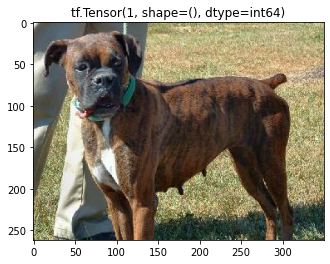

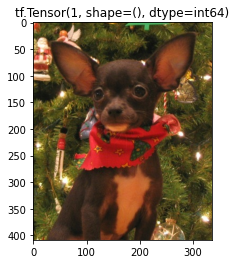

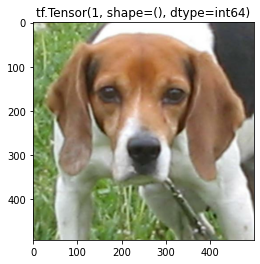

In [3]:
for image, label in ds[0][0].take(3):
    plt.figure()
    plt.title(str(label))
    plt.imshow(image)

In [4]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, label

In [5]:
BATCH_SIZE = 64
steps_per_epoch = examples//BATCH_SIZE

ds_train = ds[0][0].map(pre_process_image).shuffle(examples).repeat().batch(BATCH_SIZE)
ds_test = ds[0][1].map(pre_process_image).batch(BATCH_SIZE)

In [6]:
model = tf.keras.Sequential(name='Conv2D_Dense')
model.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "Conv2D_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 64)       

In [7]:
history = model.fit(
    ds_train,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=ds_test
)

Epoch 1/25
327/327 [==============================] - 32s 49ms/step - loss: 0.5209 - accuracy: 0.7396 - val_loss: 0.6368 - val_accuracy: 0.6264

In [8]:
print('Accuratezza in test', model.evaluate(ds_test)[1] * 100)

37/37 [==============================] - 1s 30ms/step - loss: 0.7104 - accuracy: 0.8491

In [9]:
# sosituzione dei layer Dense con un layer di GlobalMaxPooling
model_gp = tf.keras.Sequential(name='Conv2D_GlobalMaxPooling')
model_gp.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gp.add(layers.Conv2D(64, (3, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gp.add(layers.Conv2D(128, (3, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gp.add(layers.GlobalMaxPool2D())
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Dense(1))
model_gp.add(layers.Activation('sigmoid'))

model_gp.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gp.summary()

Model: "Conv2D_GlobalMaxPooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 47, 47,

In [10]:
history_gp = model_gp.fit(
    ds_train,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=ds_test
)

Epoch 1/25
327/327 [==============================] - 38s 79ms/step - loss: 0.5184 - accuracy: 0.7477 - val_loss: 1.0281 - val_accuracy: 0.5026

In [11]:
print('Accuratezza in test', model_gp.evaluate(ds_test)[1] * 100)

37/37 [==============================] - 1s 32ms/step - loss: 0.5513 - accuracy: 0.8792

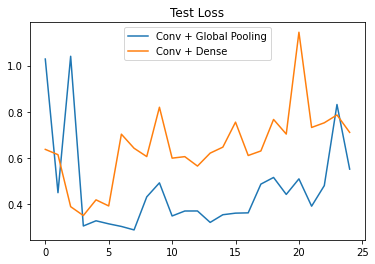

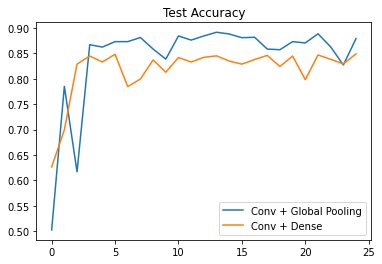

In [12]:
plt.plot(history_gp.history['val_loss'], label='Conv + Global Pooling')
plt.plot(history.history['val_loss'], label='Conv + Dense')
plt.title('Test Loss')
plt.legend()
plt.show()

plt.plot(history_gp.history['val_accuracy'], label='Conv + Global Pooling')
plt.plot(history.history['val_accuracy'], label='Conv + Dense')
plt.title('Test Accuracy')
plt.legend()
plt.show()